In [1]:
import os
import cv2

import imagehash
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [2]:
dataset_path = 'data/'

In [3]:
cat_species = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
num_cat_species = len(cat_species)

print(f"Number of types of cats: {num_cat_species}")
print("Cat species:")
print('\n'.join(cat_species))

Number of types of cats: 9
Cat species:
.ipynb_checkpoints
african-wildcat
blackfoot-cat
chinese-mountain-cat
domestic-cat
european-wildcat
jungle-cat
sand-cat
train_test


In [4]:
image_counts = {}

for species in cat_species:
    species_path = os.path.join(dataset_path, species)
    num_images = len([f for f in os.listdir(species_path) if os.path.isfile(os.path.join(species_path, f))])
    image_counts[species] = num_images

# Convert to DataFrame for better readability
image_counts_df = pd.DataFrame(list(image_counts.items()), columns=['Species', 'Number of Images'])
image_counts_df

,Species,Number of Images
0,.ipynb_checkpoints,0
1,african-wildcat,87
2,blackfoot-cat,78
3,chinese-mountain-cat,37
4,domestic-cat,59
5,european-wildcat,57
6,jungle-cat,80
7,sand-cat,67
8,train_test,1


In [5]:
# Dictionary to store the number of images for each species
image_counts = {}

for species in cat_species:
    species_path = os.path.join(dataset_path, species)
    image_files = [f for f in os.listdir(species_path) if f.endswith('.jpg')]

    image_counts[species] = len(image_files)

    print("The output format (height, width, channels):")
    
    for image_file in image_files:
        image_path = os.path.join(species_path, image_file)
        
        # Read the image 
        img = cv2.imread(image_path)
        
        if img is not None:
            print(f"{image_file}: {img.shape}")
        else:
            print(f"Error opening image {image_file}")

The output format (height, width, channels):
The output format (height, width, channels):
af (1).jpg: (190, 265, 3)
af (10).jpg: (184, 274, 3)
af (11).jpg: (183, 275, 3)
af (12).jpg: (192, 263, 3)
af (13).jpg: (219, 230, 3)
af (14).jpg: (275, 183, 3)
af (15).jpg: (183, 275, 3)
af (16).jpg: (209, 241, 3)
af (17).jpg: (168, 300, 3)
af (18).jpg: (183, 275, 3)
af (19).jpg: (195, 258, 3)
af (2).jpg: (194, 259, 3)
af (20).jpg: (258, 195, 3)
af (21).jpg: (124, 220, 3)
af (22).jpg: (225, 225, 3)
af (23).jpg: (183, 275, 3)
af (24).jpg: (192, 262, 3)
af (25).jpg: (264, 191, 3)
af (26).jpg: (258, 195, 3)
af (27).jpg: (183, 275, 3)
af (28).jpg: (183, 275, 3)
af (29).jpg: (191, 264, 3)
af (3).jpg: (225, 225, 3)
af (30).jpg: (194, 259, 3)
af (31).jpg: (201, 250, 3)
af (33).jpg: (259, 195, 3)
af (34).jpg: (225, 225, 3)
af (35).jpg: (183, 275, 3)
af (36).jpg: (190, 265, 3)
af (38).jpg: (267, 189, 3)
af (39).jpg: (190, 265, 3)
af (4).jpg: (185, 272, 3)
af (40).jpg: (192, 262, 3)
af (41).jpg: (183, 275,

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

Let's get the perceptual hash of an image fith this function:

In [6]:
def get_image_hash(image_path):
    try:
        # Open the image using PIL
        with Image.open(image_path) as img:
            # Compute and return the perceptual hash of the image
            return imagehash.phash(img)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

image_hashes = {}
duplicate_images = []

for species in os.listdir(dataset_path):
    species_path = os.path.join(dataset_path, species)
    
    if os.path.isdir(species_path):
        for image_file in os.listdir(species_path):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(species_path, image_file)
                
                # Compute the perceptual hash of the image
                img_hash = get_image_hash(image_path)
                
                if img_hash is not None:
                    if img_hash in image_hashes:
                        duplicate_images.append(image_path)
                    else:
                        image_hashes[img_hash] = image_path

print("\nDuplicate images:")
for img in duplicate_images:
    print(img)


Duplicate images:


In [7]:
for img in duplicate_images:
    os.remove(img)
    print(f"Removed {img}")

print("\nDuplicate image detection completed.")


Duplicate image detection completed.


### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [8]:
# Load the pre-trained ResNet50 model with weights trained on ImageNet
model = tf.keras.applications.ResNet50(weights='imagenet')

# Display the model architecture
model.summary()

# Get the total number of layers
num_layers = len(model.layers)
print(f"Total number of layers: {num_layers}")

# Get the total number of parameters
total_params = model.count_params()
print(f"Total number of parameters: {total_params}")

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

Total number of layers: 177
Total number of parameters: 25636712


### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [9]:
# Set the required image dimensions for the model
image_height = 224
image_width = 224

# Here we will store the processed images
images = []

# Iterate over each category (species) directory in the dataset
for species in os.listdir(dataset_path):
    species_path = os.path.join(dataset_path, species)
    
    # Check if it is a directory
    if os.path.isdir(species_path):
        for image_file in os.listdir(species_path):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(species_path, image_file)
                image = cv2.imread(image_path)
                
                if image is not None:
                    # Resize the image
                    resized_image = cv2.resize(image, (image_height, image_width))

                    # Preprocess the image for ResNet50
                    preprocessed_image = tf.keras.applications.resnet50.preprocess_input(resized_image)
                    
                    # Append the processed image to the list
                    images.append(preprocessed_image)

# Convert the list to a NumPy array
images_np = np.array(images)

# Check if the images are resized successfully
images_np.shape

(465, 224, 224, 3)

In [10]:
# Save the processed images as a .npy file
output_dir = "train_test"
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, 'images_test.npy'), images_np)

# Load the .npy file to verify
loaded_images = np.load(os.path.join(output_dir, 'images_test.npy'))

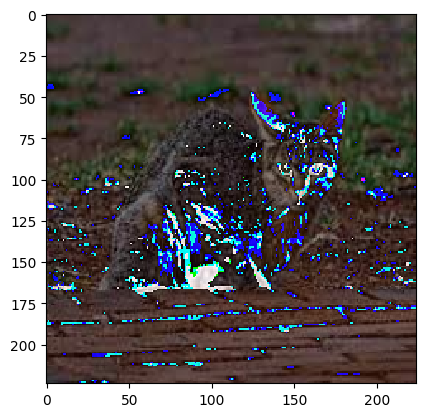

In [11]:
# Plot an example image
plt.imshow(loaded_images[24].astype(np.uint8), interpolation='nearest')
plt.show()

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [16]:
# def image_generator(dataset_path, batch_size=4, image_height=224, image_width=224):
#     """Generator to yield batches of preprocessed images."""
#     image_files = []
#     for species in os.listdir(dataset_path):
#         species_path = os.path.join(dataset_path, species)
#         if os.path.isdir(species_path):
#             for image_file in os.listdir(species_path):
#                 if image_file.endswith('.jpg'):
#                     image_files.append(os.path.join(species_path, image_file))
                    
#     num_files = len(image_files)
#     while True:
#         for start in range(0, num_files, batch_size):
#             batch_files = image_files[start:start+batch_size]
#             batch_images = []
#             for file in batch_files:
#                 image = cv2.imread(file)
#                 if image is not None:
#                     resized_image = cv2.resize(image, (image_height, image_width))
#                     preprocessed_image = tf.keras.applications.resnet50.preprocess_input(resized_image)
#                     batch_images.append(preprocessed_image)
#             yield np.array(batch_images)

# batch_size = 4
# image_height = 224
# image_width = 224

# generator = image_generator(dataset_path, batch_size, image_height, image_width)

# # Fetch a batch
# batch_images = next(generator)
# print(batch_images.shape)  # Should be (batch_size, image_height, image_width, 3)

In [15]:
# def save_preprocessed_images(dataset_path, output_dir, image_height=224, image_width=224):
#     """Preprocess and save images to disk."""
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
        
#     for species in os.listdir(dataset_path):
#         species_path = os.path.join(dataset_path, species)
#         if os.path.isdir(species_path):
#             output_species_dir = os.path.join(output_dir, species)
#             if not os.path.exists(output_species_dir):
#                 os.makedirs(output_species_dir)
            
#             for image_file in os.listdir(species_path):
#                 if image_file.endswith('.jpg'):
#                     image_path = os.path.join(species_path, image_file)
#                     image = cv2.imread(image_path)
#                     if image is not None:
#                         resized_image = cv2.resize(image, (image_height, image_width))
#                         preprocessed_image = tf.keras.applications.resnet50.preprocess_input(resized_image)
#                         # Save the preprocessed image
#                         output_path = os.path.join(output_species_dir, image_file.replace('.jpg', '.npy'))
#                         np.save(output_path, preprocessed_image)

# output_dir = 'train_test'
# save_preprocessed_images(dataset_path, output_dir)

In [17]:
# def load_preprocessed_images_from_disk(dataset_path, batch_size=4):
#     """Generator to yield batches of preprocessed images from disk."""
#     image_files = []
#     for species in os.listdir(dataset_path):
#         species_path = os.path.join(dataset_path, species)
#         if os.path.isdir(species_path):
#             for image_file in os.listdir(species_path):
#                 if image_file.endswith('.npy'):
#                     image_files.append(os.path.join(species_path, image_file))
                    
#     num_files = len(image_files)
#     while True:
#         for start in range(0, num_files, batch_size):
#             batch_files = image_files[start:start+batch_size]
#             batch_images = []
#             for file in batch_files:
#                 image = np.load(file)
#                 batch_images.append(image)
#             yield np.array(batch_images)

# # Example usage
# dataset_path = 'train_test'
# batch_size = 4

# generator = load_preprocessed_images_from_disk(dataset_path, batch_size)

# # Fetch a batch
# batch_images = next(generator)
# print(batch_images.shape)  # Should be (batch_size, image_height, image_width, 3)
# print("Finish")

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf

# Set the required image dimensions for the model
image_height = 224
image_width = 224

# Define the batch size
batch_size = 4

# Path to the dataset
processed_path = 'train_test'

# Ensure the processed directory exists
os.makedirs(processed_path, exist_ok=True)

def process_images_batch(image_paths):
    """Process a batch of images."""
    images = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        if image is not None:
            # Resize the image
            resized_image = cv2.resize(image, (image_width, image_height))
            # Preprocess the image for ResNet50
            preprocessed_image = tf.keras.applications.resnet50.preprocess_input(resized_image)
            images.append(preprocessed_image)
    return np.array(images)

def save_batch(batch_index, batch_images):
    """Save a batch of preprocessed images."""
    np.save(os.path.join(processed_path, f'batch_{batch_index}.npy'), batch_images)

def load_and_process_images():
    """Load and process images in batches."""
    # Get a list of all image files
    all_image_files = []
    for species in os.listdir(dataset_path):
        species_path = os.path.join(dataset_path, species)
        if os.path.isdir(species_path):
            for image_file in os.listdir(species_path):
                if image_file.endswith('.jpg'):
                    all_image_files.append(os.path.join(species_path, image_file))
    
    # Process images in batches
    num_batches = len(all_image_files) // batch_size + (1 if len(all_image_files) % batch_size != 0 else 0)
    for batch_index in range(num_batches):
        start = batch_index * batch_size
        end = min(start + batch_size, len(all_image_files))
        batch_paths = all_image_files[start:end]
        
        print(f"Processing batch {batch_index + 1}/{num_batches}...")
        batch_images = process_images_batch(batch_paths)
        save_batch(batch_index, batch_images)

if __name__ == '__main__':
    load_and_process_images()


### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.